In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/home/jarvis07/Downloads/yassir2-17c08dd131c5.json'
from google.cloud import bigquery
client=bigquery.Client()

In [172]:
import warnings
warnings.filterwarnings('ignore')
import dash
import dash_core_components as dcc
import dash_html_components as html
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import plotly.express as xp
import itertools as it
import operator
import plotly.express as px
%matplotlib inline


In [6]:
def create_id(df):
    df2=df.copy()
    for i in np.arange(0,df.shape[0]):
        df2.loc[i,'id']=i   
    return df2

def takeoff_rfm(df):
    return df[['id','driver','freq','money','recency','avg_diff']]
    

def rmv_outliers(df,list_variable,quant1,quant3):
    # Removing (statistical) outliers 
    for variable in list_variable:
        Q1 = df[variable].quantile(quant1)
        Q3 = df[variable].quantile(quant3)
        IQR = Q3 - Q1
        df2= df[(df[variable] >= Q1 - 1.5*IQR) & (df[variable] <= Q3 +1.5*IQR)]
    return df2


def rec_class(serie):
    if serie<=4 :
        return 3
    elif serie<=30:
        return 2
    else:
        return 1
    
def kmeans_all(df,variables,number):
    data_std=pd.DataFrame(StandardScaler().fit_transform(df[variables]),columns=[variables])
    kmeans = KMeans(number, max_iter=90)
    kmeans.fit(data_std[variables])
    cluster_labels = kmeans.labels_
    fig = px.scatter_3d(df, x=variables[0], y=variables[1] , z=variables[2],opacity=1,size_max=0.5,color=cluster_labels)
    fig.show()
    return cluster_labels

def kmeans_tuning(datarff,variables):

    datarff_std=pd.DataFrame(StandardScaler().fit_transform(datarff[variables]),columns=[variables])
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
    ssd=[]
    for num_clusters in range_n_clusters:

        # intialise kmeans
        kmeans = KMeans(n_clusters=num_clusters, max_iter=90)
        kmeans.fit(datarff_std[['freq','work_duration','recency']])

        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg = silhouette_score(datarff_std[['freq','work_duration','recency']], cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1},inertia is {2}".format(num_clusters, silhouette_avg,kmeans.inertia_))
        ssd.append(kmeans.inertia_)

    # plot the SSDs for each n_clusters
    plt.plot(ssd)

# PART1 : 
## >> Import the dataset using sql from bigquery 

>> Clusster1 variable is to classify to actif mid and inactif

>>clusster 2 is to classify drivers of mid category to actif inactif and mid_mid

In [7]:
# Query for bigquery
que= """
    SELECT *
    FROM CHICAGO.taxifinal2
    """

que3= """
    SELECT *
    FROM CHICAGO.taxitfinal3
    """
q=client.query(que)
df=q.to_dataframe() #Dataframe of first semester
q3=client.query(que3)
df3=q3.to_dataframe() #Dataframe ast term

In [9]:
df.head()

,driver,freq,last_trip,duree,duree_trip,duree_month,dist,dist_trip,money,mon_trip,mon_month,recency,avg_diff,work_duration
0,2eef4233ce1d3ce24a463f9e17172e8a4d450d52c016ac...,2,2018-03-12 16:00:00+00:00,1175,587.5,195.833333,18.14,9.07,45.65,22.825,7.608333,111,0.0,0
1,9d01f0a0e827dabe1826eeca4934668f74f1dc976b0945...,5,2018-01-01 14:30:00+00:00,4980,996.0,830.000000,39.50,7.90,111.50,22.300,18.583333,181,0.0,0
2,7693ff2a2bcbd2540da7abe92e7c3b4a3c2bf06f9a9875...,5,2018-01-01 03:15:00+00:00,4260,852.0,710.000000,22.00,4.40,72.25,14.450,12.041667,181,0.0,0
3,4c2abceffcdab0450f97ef953c1df2023f0a53099347c8...,3,2018-03-28 09:30:00+00:00,1560,520.0,260.000000,6.60,2.20,27.75,9.250,4.625000,95,0.0,0
4,5b7f5a9a2eafe770e4cc6af6ada3569a0080f75f3d6985...,2,2018-02-12 19:00:00+00:00,2888,1444.0,481.333333,20.50,10.25,50.40,25.200,8.400000,139,0.0,0


## The most relevant  variables used and that will describe better the behaviour of the     drivers :

* freq :frequency over last 6 months
* dist_trip :average distance for each trip 
* duree_trip :average duration for each trip
* recency :difference between reference day '2018-07-01' and last trip
* avg_diff : average deference between each two trips
* money :total amount of the driver for 6 months

# Exploring each variable and the distribution of drivers behaviour:

In [174]:
fig = px.histogram(df,x=df.freq/24,nbins=300,title='Histogram of frequencies Per week'
                  ,color_discrete_sequence=['red'], labels={'x':'frequency'})
fig.show()

In [164]:
fig = px.histogram(df,x=df.dist_trip,nbins=20,title='Histogram of distance Per trip'
                  ,color_discrete_sequence=['red'], labels={'x':'distance average'})
fig.show()
fig = px.histogram(df,x=df[df.dist_trip<20].dist_trip,nbins=50,title='Histogram of distance Per trip Without Long trips'
                  ,color_discrete_sequence=['red'], labels={'x':'distance average'})
fig.show()

In [170]:

fig = px.histogram(df,x=df.recency,nbins=10,title='Histogram of Recency distribution'
                  ,color_discrete_sequence=['red'], labels={'x':'Recency'})
fig.show()

fig = px.histogram(df,x=df[df.recency<20].recency,nbins=200,title='Histogram of Recency distribution'
                  ,color_discrete_sequence=['red'], labels={'x':'Recency'})
fig.show()

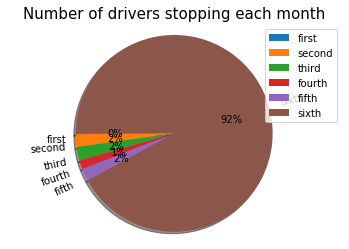

In [169]:
stoped=[df[df.recency>180].driver.count(),df[(df.recency>=120) & (df.recency<150)].driver.count(),df[(df.recency<120 )& (df.recency>=90)].driver.count(),df[(df.recency<90) & (df.recency>=60)].driver.count(),df[(df.recency>=30) & (df.recency<60)].driver.count(),df[df.recency<30].driver.count()]
labels=['first','second','third','fourth','fifth','sixth']
fig1, ax1 = plt.subplots()
ax1.pie(stoped, labels=labels , autopct='%1.0f%%',
        shadow=True, startangle=180,rotatelabels=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Number of drivers stopping each month',size=15)
fig1.figsize=(50,50)
plt.legend()
plt.show()

In [173]:
fig = px.histogram(df,x=df.work_duration,nbins=10,title='Histogram of Recency distribution'
                  ,color_discrete_sequence=['red'], labels={'x':'Recency'})
fig.show()

# Study Recency-freeze-relative frequency

In [11]:
datarff=df[['driver','freq','avg_diff','recency','work_duration']]
datarff['fre_rel']=datarff['freq']/datarff['work_duration']

In [28]:
test=datarff.copy()
old=test[test.work_duration+test.recency>30].driver #old drivers 
dataold=datarff[datarff.driver.isin(old)]
print('percentage of old drivers more then one month',dataold.shape[0]/datarff.shape[0])

percentage of old drivers more then one month 0.9925411968777104


For n_clusters=2, the silhouette score is 0.6965806809828504,inertia is 7753.9192752858635
For n_clusters=3, the silhouette score is 0.43435545463057307,inertia is 4795.124205707103
For n_clusters=4, the silhouette score is 0.47729651410196205,inertia is 3172.247663067006
For n_clusters=5, the silhouette score is 0.45431259811246155,inertia is 2407.382407326287
For n_clusters=6, the silhouette score is 0.4580147926635173,inertia is 1930.137455253273
For n_clusters=7, the silhouette score is 0.443587722297261,inertia is 1585.068416584566
For n_clusters=8, the silhouette score is 0.45632433814056556,inertia is 1334.5835099141411


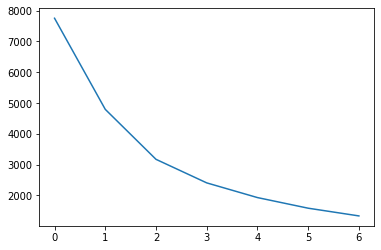

In [29]:
kmeans_tuning(dataold,['freq','recency','work_duration','avg_diff'])

In [32]:
dataold.columns

Index(['driver', 'freq', 'avg_diff', 'recency', 'work_duration', 'fre_rel',
       'cluster'],
      dtype='object')

In [41]:
dataold.loc[:,'cluster'] =kmeans_all(dataold,['recency','freq','avg_diff'],5)

In [64]:
dataold.groupby('cluster').count()

,driver,freq,avg_diff,recency,work_duration,fre_rel
cluster,,,,,,
0,1063,1063,1063,1063,1063,1063
1,413,413,413,413,413,413
2,1552,1552,1552,1552,1552,1552
3,6,6,6,6,6,6
4,2688,2688,2688,2688,2688,2688


In [65]:
dataold.groupby('cluster').mean()

,freq,avg_diff,recency,work_duration,fre_rel
cluster,,,,,
0,1982.291627,0.092005,1.533396,177.845720,11.156021
1,261.305085,0.748240,127.602906,49.455206,inf
2,545.536727,0.592854,5.767397,154.337629,inf
3,3.000000,62.750000,57.000000,106.166667,0.028470
4,1209.388021,0.147072,2.513765,173.026786,7.065123


In [84]:
In1=dataold.loc[(dataold['cluster']==1)]
In2=dataold.loc[(dataold['cluster']==3)]
inactif=pd.concat([In1,In2], axis=0)
average=dataold.loc[(dataold['cluster']==2)]
x=dataold.loc[(dataold['cluster']==0)]
y=dataold.loc[(dataold['cluster']==4)]
actif=pd.concat([x,y], axis=0)
distr=[actif.shape[0],inactif.shape[0],average.shape[0]]

def classement(dataold):
    if (dataold==1)|(dataold==3):
        return'inactif'
    elif  (dataold==0)|(dataold==4):
        return'actif'
    else:
        return'average'

dataold['class']=dataold.cluster.apply(classement)

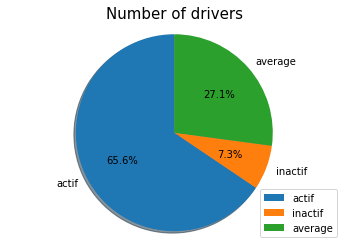

In [85]:
fig1, ax1 = plt.subplots()
ax1.pie(distr, labels=['actif','inactif','average'] , autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Number of drivers',size=15)
plt.legend()
plt.show()


# Check the accuracy of actif/inactif prediction

In [96]:
print('accuracy of inactif is '+str((1-df3[df3['driver'].isin(inactif.driver)].count()[0]/inactif.driver.count())*100))
print('accuracy of inactif is '+str((df3[df3['driver'].isin(actif.driver)].count()[0]/actif.driver.count())*100))

accuracy of inactif is 89.49880668257757
accuracy of inactif is 92.69528125833111


# Verifier si ces Inactif ont arretes ? et donc comparer avec dernier trimestre de 2018

In [32]:
df3.shapeD

(4873, 14)

In [33]:
df3[df3['driver'].isin(inactif.driver)].describe()

,freq,freq_month,duree,duree_trip,duree_month,dist,dist_month,dist_trip,money,mon_trip,mon_month,recency
count,2369.000000,2369.000000,2.369000e+03,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000
mean,469.735331,78.289222,6.068547e+05,1376.252952,101142.442381,2958.660984,493.110164,6.799084,9667.168628,21.998024,1611.194771,6.433094
std,203.561089,33.926848,2.514528e+05,519.718030,41908.797776,1583.101829,263.850305,3.653829,5066.111727,9.775447,844.351955,12.845753
min,1.000000,0.166667,3.000000e+02,300.000000,50.000000,1.100000,0.183333,0.204113,5.750000,5.750000,0.958333,0.000000
25%,334.000000,55.666667,4.601400e+05,1051.067961,76690.000000,1934.500000,322.416667,4.262059,7150.000000,15.968023,1191.666667,1.000000
50%,456.000000,76.000000,5.990400e+05,1286.122558,99840.000000,2980.600000,496.766667,6.263710,9508.500000,20.402119,1584.750000,1.000000
75%,585.000000,97.500000,7.468800e+05,1600.776699,124480.000000,3902.530000,650.421667,9.130460,11928.250000,26.705993,1988.041667,4.000000
max,1832.000000,305.333333,2.967154e+06,10435.271739,494525.666667,9827.980000,1637.996667,19.037675,172284.600000,327.537262,28714.100000,92.000000


# Verifier si les Actifs sont toujours present fin 2018:

In [34]:
df3[df3['driver'].isin(Actif.driver)].describe()

,freq,freq_month,duree,duree_trip,duree_month,dist,dist_month,dist_trip,money,mon_trip,mon_month,recency
count,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.000000,1.000000,1.0
mean,3.0,0.5,3456.0,1152.0,576.0,20.7,3.45,6.9,62.0,20.666667,10.333333,58.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.0,0.5,3456.0,1152.0,576.0,20.7,3.45,6.9,62.0,20.666667,10.333333,58.0
25%,3.0,0.5,3456.0,1152.0,576.0,20.7,3.45,6.9,62.0,20.666667,10.333333,58.0
50%,3.0,0.5,3456.0,1152.0,576.0,20.7,3.45,6.9,62.0,20.666667,10.333333,58.0
75%,3.0,0.5,3456.0,1152.0,576.0,20.7,3.45,6.9,62.0,20.666667,10.333333,58.0
max,3.0,0.5,3456.0,1152.0,576.0,20.7,3.45,6.9,62.0,20.666667,10.333333,58.0


In [35]:

mid.describe()

,freq,avg_diff,recency,work_duration,fre_rel,cluster
count,2598.000000,2598.000000,2598.000000,2598.00000,2598.000000,2598.000000
mean,1470.013087,0.274144,4.677444,158.39338,inf,3.198999
std,604.503094,1.683813,13.311899,40.90582,NaN,1.612442
min,2.000000,0.000000,0.000000,0.00000,0.032051,0.000000
25%,1316.000000,0.095598,1.000000,163.00000,7.722222,4.000000
50%,1511.000000,0.112882,1.000000,179.00000,8.868168,4.000000
75%,1796.000000,0.129630,1.000000,180.00000,10.477048,4.000000
max,3763.000000,39.000000,112.000000,181.00000,inf,5.000000


Text(0.5, 0, 'Attributes')

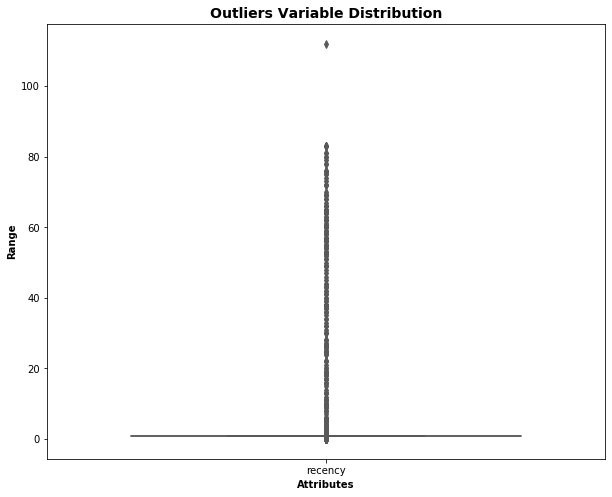

In [36]:
attributes = ['recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = mid[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

# 2 layer  of the model working on the mid clussters to segment them:

In [37]:
mid.describe()

,freq,avg_diff,recency,work_duration,fre_rel,cluster
count,2598.000000,2598.000000,2598.000000,2598.00000,2598.000000,2598.000000
mean,1470.013087,0.274144,4.677444,158.39338,inf,3.198999
std,604.503094,1.683813,13.311899,40.90582,NaN,1.612442
min,2.000000,0.000000,0.000000,0.00000,0.032051,0.000000
25%,1316.000000,0.095598,1.000000,163.00000,7.722222,4.000000
50%,1511.000000,0.112882,1.000000,179.00000,8.868168,4.000000
75%,1796.000000,0.129630,1.000000,180.00000,10.477048,4.000000
max,3763.000000,39.000000,112.000000,181.00000,inf,5.000000


For n_clusters=2, the silhouette score is 0.6895255865974567,inertia is 13598.581152328235
For n_clusters=3, the silhouette score is 0.6828329509847235,inertia is 9715.997206864231
For n_clusters=4, the silhouette score is 0.41854239076939875,inertia is 6905.401314658942
For n_clusters=5, the silhouette score is 0.46541128868869175,inertia is 5047.889911178129
For n_clusters=6, the silhouette score is 0.4696663022520949,inertia is 4169.735879042718
For n_clusters=7, the silhouette score is 0.44331619787642484,inertia is 3417.90530192032
For n_clusters=8, the silhouette score is 0.4466332149811796,inertia is 2915.004876701979


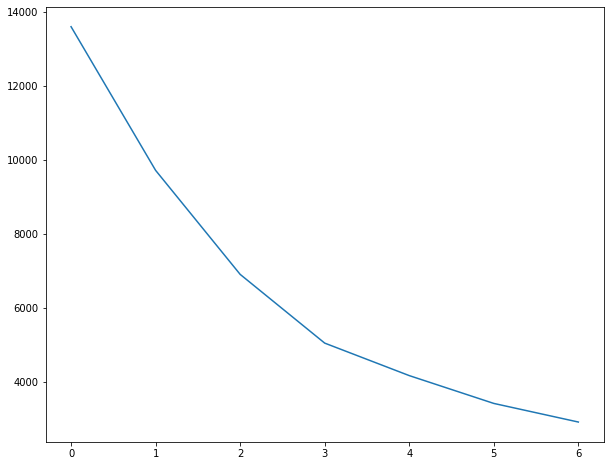

In [38]:
mid_std=pd.DataFrame(StandardScaler().fit_transform(datarff[['freq','work_duration','recency','avg_diff']]),columns=[['freq','work_duration','recency','avg_diff']])
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
ssd=[]
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=90)
    kmeans.fit(mid_std[['freq','work_duration','recency','avg_diff']])
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(mid_std[['freq','work_duration','recency','avg_diff']], cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1},inertia is {2}".format(num_clusters, silhouette_avg,kmeans.inertia_))
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [39]:
mid.loc[:,'cluster2'] =kmeans_all(mid,['recency','avg_diff','freq','work_duration'],5)

In [40]:
mid.groupby('cluster2').describe()

freq                                                             \
           count         mean         std     min      25%     50%      75%   
cluster2                                                                      
0          526.0  2245.387833  298.178837  1889.0  2013.25  2167.5  2391.75   
1          406.0   568.477833  343.496888     2.0   301.50   554.0   821.00   
2          131.0   560.839695  417.751910     3.0   206.50   503.0   798.50   
3           14.0     6.785714    2.860300     4.0     5.00     5.0     8.50   
4         1521.0  1534.288626  164.427076  1286.0  1395.00  1514.0  1660.00   

                 avg_diff             ...    fre_rel            cluster  \
             max    count       mean  ...        75%        max   count   
cluster2                              ...                                 
0         3763.0    526.0   0.080887  ...  13.454949  20.790055   526.0   
1         1463.0    406.0   0.263389  ...   9.534922  21.000000   406.0   
2         1727.0    131.0   0.697080  ...   7.224320        inf   131.0   
3           13.0     14.0  20.997619  ...   0.076515   0.089286    14.0   
4         1888.0   1521.0   0.116673  ...   9.423611  14.635659  1521.0   

                                                       
              mean       std  min  25%  50%  75%  max  
cluster2                                               
0         4.000000  0.000000  4.0  4.0  4.0  4.0  4.0  
1         0.036946  0.428739  0.0  0.0  0.0  0.0  5.0  
2         0.290076  1.077665  0.0  0.0  0.0  0.0  5.0  
3         5.000000  0.000000  5.0  5.0  5.0  5.0  5.0  
4         4.000000  0.000000  4.0  4.0  4.0  4.0  4.0  

[5 rows x 48 columns]

>> Clusster 2 has a very low frequency and very high average diff so we can class them as inactif 
>> cluster 1 has very high frequency and low recency 

In [41]:
inactif_mid=mid[mid['cluster2']==4]
actif_mid=mid[mid['cluster2']==0]


In [42]:
df3[df3['driver'].isin(inactif_mid.driver)].describe()

,freq,freq_month,duree,duree_trip,duree_month,dist,dist_month,dist_trip,money,mon_trip,mon_month,recency
count,1427.000000,1427.000000,1.427000e+03,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000
mean,660.680448,110.113408,7.330504e+05,1155.769675,122175.060266,3364.081310,560.680218,5.345966,11649.257155,18.371207,1941.542859,5.283111
std,218.334420,36.389070,2.597208e+05,359.057616,43286.797405,1523.528816,253.921469,2.515509,13367.690050,17.322995,2227.948342,11.220461
min,2.000000,0.333333,5.671000e+03,584.625000,945.166667,26.200000,4.366667,0.241083,76.500000,9.101562,12.750000,0.000000
25%,528.000000,88.000000,5.943280e+05,937.845026,99054.666667,2465.600000,410.933333,3.815148,9039.500000,14.084312,1506.583333,1.000000
50%,659.000000,109.833333,7.226400e+05,1074.797659,120440.000000,3315.210000,552.535000,4.997390,11117.250000,16.683399,1852.875000,1.000000
75%,797.000000,132.833333,8.575935e+05,1271.957646,142932.250000,4210.185000,701.697500,6.547822,13436.250000,20.301876,2239.375000,2.000000
max,1993.000000,332.166667,3.199324e+06,5127.121795,533220.666667,11559.420000,1926.570000,16.021429,496342.950000,638.794015,82723.825000,92.000000


In [43]:
df3[df3['driver'].isin(actif_mid.driver)].describe()

,freq,freq_month,duree,duree_trip,duree_month,dist,dist_month,dist_trip,money,mon_trip,mon_month,recency
count,494.000000,494.000000,4.940000e+02,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,907.589069,151.264845,8.894724e+05,1016.774169,148245.403846,4029.282146,671.547024,4.658098,13811.144251,15.898906,2301.857375,4.763158
std,300.560847,50.093474,3.149822e+05,260.988070,52497.026181,1651.670274,275.278379,2.067244,4401.786994,4.327564,733.631166,11.873342
min,29.000000,4.833333,3.270400e+04,643.502825,5450.666667,142.200000,23.700000,0.261649,680.500000,9.715035,113.416667,0.000000
25%,704.250000,117.375000,7.111172e+05,849.007406,118519.541667,3196.000000,532.666667,3.511787,11017.250000,12.975187,1836.208333,1.000000
50%,946.500000,157.750000,8.830500e+05,953.268392,147175.000000,3956.800000,659.466667,4.283805,13438.125000,14.793493,2239.687500,1.000000
75%,1112.000000,185.333333,1.041735e+06,1102.753534,173622.500000,4896.900000,816.150000,5.442627,16380.750000,17.557955,2730.125000,1.000000
max,1777.000000,296.166667,4.394735e+06,3198.497089,732455.833333,10532.200000,1755.366667,21.440085,32567.500000,38.070115,5427.916667,85.000000


>> In the mid class the accuracy of the actif mid class is 92,5% and accuracy of mid class inactif is 90% 

# Final division of actif and inactif drivers:

In [44]:
actif_final=pd.concat([actif_mid,Actif],axis=0)
inactif_final=pd.concat([inactif_mid,inactif],axis=0)

In [45]:
inactif_final.shape

(4683, 8)

In [46]:
print(f'actif final number is ={0} and inactif number is ={1}',actif_final.shape,inactif_final.shape)

actif final number is =0 and inactif number is =1 (531, 8) (4683, 8)


# Check final accuracy:

In [47]:
acti_stay=df3[df3['driver'].isin(actif_final.driver)].count()[1]
inactif_stay=df3[df3['driver'].isin(inactif_final.driver)].count()[1]

In [48]:
print('Accuracy for actif drivers is ='+str((acti_stay/actif_final.shape[0])*100),'Accuracy for inactif drivers is '+str(100-(inactif_stay/inactif_final.shape[0])*100))

Accuracy for actif drivers is =93.22033898305084 Accuracy for inactif drivers is 18.94084988255392


In [49]:
mid_mid=pd.concat([mid[mid['cluster2']==1],mid[mid['cluster2']==3],mid[mid['cluster2']==2]],axis=0)
mid_mid

,driver,freq,avg_diff,recency,work_duration,fre_rel,cluster,cluster2
19,718cf30bdec0812def95c6ece3506125b6ba91031069c3...,11,0.100000,1,1,11.000000,0,1
22,62bebcd4044f7bc6dfeab421a58c96db5ec7ba234cf7d6...,2,1.000000,32,1,2.000000,0,1
25,01cfdf564af1a522661ba984b93574d481b54e27516833...,17,0.062500,1,1,17.000000,0,1
26,178164356abfb5bfea80a94a7266c1502a656dff8bbc3c...,7,0.166667,1,1,7.000000,0,1
28,92195ba6d79380aa9da1f2db98ac05a3eff859c4151f24...,5,0.250000,1,1,5.000000,0,1
...,...,...,...,...,...,...,...,...
955,a6b15fdc3bb5e16577b259bd01d9106bd500b887612acb...,1510,0.088801,46,134,11.268657,4,2
1036,ea73ddfdd7cafa796ab1e254ffe3240fb6936e6f390c27...,1719,0.083236,38,143,12.020979,4,2
1048,e3d1ed9d4a533ba9a039e62350a7bc16cc4bb7cb346559...,1540,0.093567,37,144,10.694444,4,2
854,4ed663ed9edc847880b698b6f4ec3be33030d7e16ecc92...,14,9.384615,31,122,0.114754,5,2


>> actif_final has accuracy of 93% 3993 person

>> inactif_final has accuracy of 90% 402 person

>> mid_mid has 1370 person they have nearly the same avg_diff so we will apply kmeans with frequency recency and work duration

Text(0.5, 0, 'Attributes')

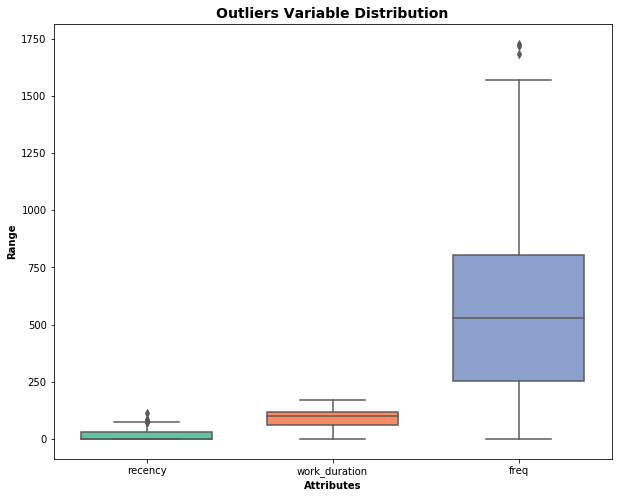

In [50]:
attributes = ['recency','work_duration','freq']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = mid_mid[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Text(0.5, 0, 'Attributes')

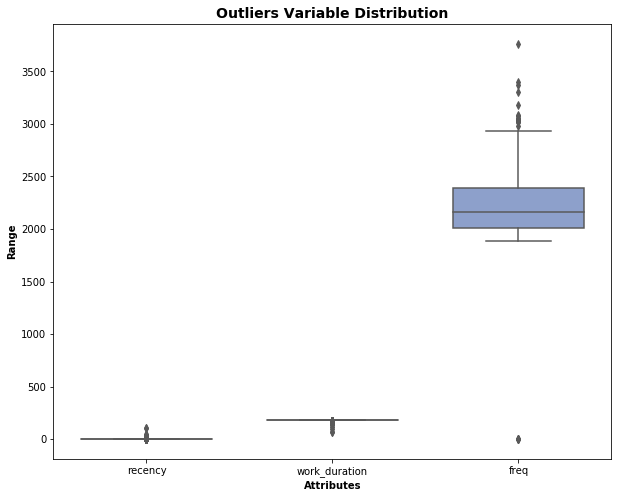

In [51]:
attributes = ['recency','work_duration','freq']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = actif_final[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

# In our study we will remove the inactif ones because they will go anyway:so we keep actif_final and mid_mid

In [52]:
actif_final.describe()

,avg_diff,cluster,cluster2,fre_rel,freq,recency,work_duration
count,531.000000,531.000000,526.0,531.000000,531.000000,531.000000,531.000000
mean,0.715718,3.990584,0.0,12.451392,2224.269303,1.806026,177.960452
std,6.907439,0.096670,0.0,2.075243,367.530624,7.251938,9.433798
min,0.048113,3.000000,0.0,0.017857,2.000000,0.000000,64.000000
25%,0.074479,4.000000,0.0,11.222858,2011.500000,1.000000,179.000000
50%,0.082460,4.000000,0.0,12.132597,2166.000000,1.000000,180.000000
75%,0.089148,4.000000,0.0,13.432121,2390.500000,1.000000,180.000000
max,112.000000,4.000000,0.0,20.790055,3763.000000,106.000000,181.000000


In [53]:
mid_mid.describe()

,freq,avg_diff,recency,work_duration,fre_rel,cluster,cluster2
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,552.390200,0.893321,16.194192,87.854809,inf,0.223230,1.288566
std,368.671515,3.591445,25.111107,37.320050,NaN,1.008638,0.506535
min,2.000000,0.000000,0.000000,0.000000,0.032051,0.000000,1.000000
25%,255.500000,0.109072,1.000000,60.000000,4.444254,0.000000,1.000000
50%,528.000000,0.146825,1.000000,99.000000,6.837838,0.000000,1.000000
75%,804.000000,0.227254,30.500000,117.000000,9.177149,0.000000,2.000000
max,1727.000000,39.000000,112.000000,171.000000,inf,5.000000,3.000000


In [54]:
actif_final_inner = pd.merge(left=actif_final,right=df, left_on='driver', right_on='driver')
inactif_final_inner = pd.merge(left=inactif_final,right=df, left_on='driver', right_on='driver')
mid_mid_inner=pd.merge(left=mid_mid,right=df, left_on='driver', right_on='driver')

In [55]:
actif_money=actif_final_inner['money'].sum()
inactif_money=inactif_final_inner['money'].sum()
mid_money=mid_mid_inner['money'].sum()


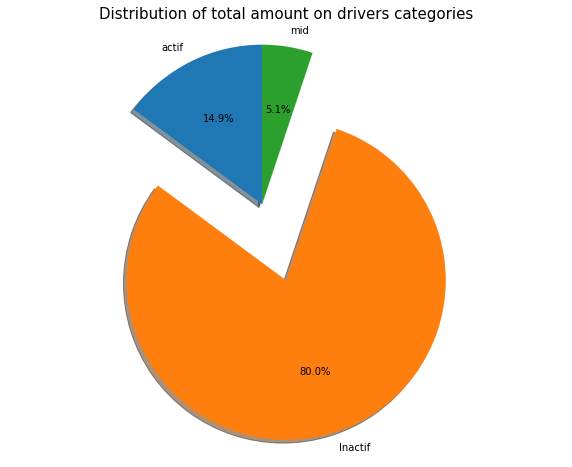

In [56]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'actif', 'Inactif', 'mid'
sizes = [actif_money,inactif_money,mid_money]
explode = (0, 0.5, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of total amount on drivers categories',size=15)
plt.show()


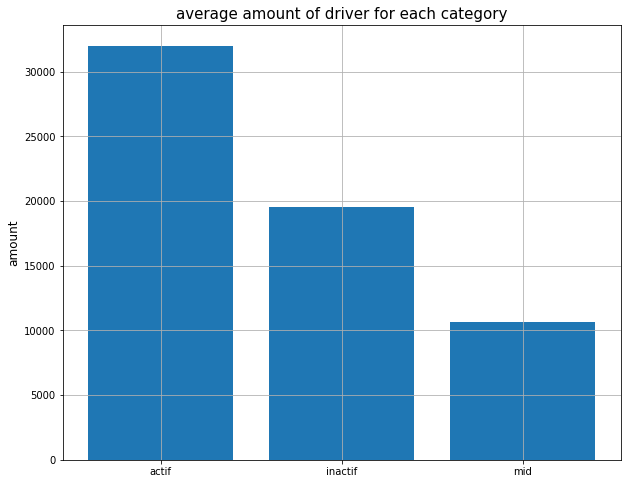

In [57]:
actif_money=actif_final_inner['money'].sum()/actif_final_inner.money.count()
inactif_money=inactif_final_inner['money'].sum()/inactif_final_inner.money.count()
mid_money=mid_mid_inner['money'].sum()/mid_mid_inner['money'].count()
plt.bar(x=['actif','inactif','mid'],height=[actif_money,inactif_money,mid_money])
plt.title('average amount of driver for each category',size=15)
plt.ylabel('amount',size=12)
plt.grid()

# Study of actif drivers which is the most important part of our business:

Text(0.5, 0, 'Attributes')

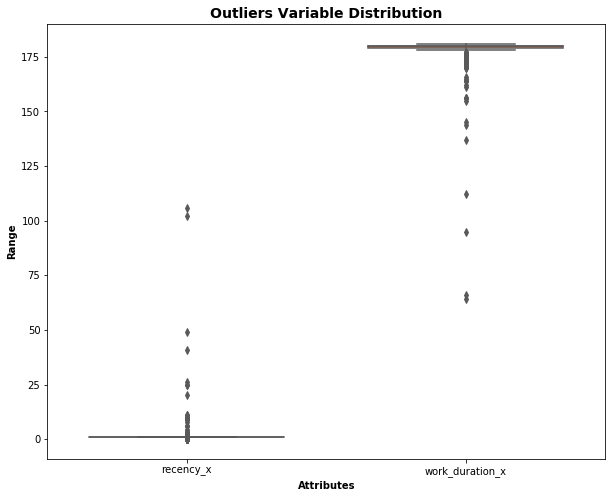

In [58]:
attributes = ['recency_x','work_duration_x']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data =actif_final_inner[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [59]:
actif_final_inner['act_cluster']=kmeans_all(actif_final_inner,['recency_x','freq_x','money'],3)

In [60]:
actif_final_inner.groupby('act_cluster').mean()

,avg_diff_x,cluster,cluster2,fre_rel,freq_x,recency_x,work_duration_x,freq_y,duree,duree_trip,duree_month,dist,dist_trip,money,mon_trip,mon_month,recency_y,avg_diff_y,work_duration_y
act_cluster,,,,,,,,,,,,,,,,,,,
0,67.500000,3,NaN,0.027753,2.600000,63.600000,96.200000,2.600000,3.223200e+03,1187.166667,537.200000,180.660000,60.181667,1278.828000,427.037667,213.138000,63.600000,67.500000,96.200000
1,0.071959,4,0.0,14.134567,2526.537572,1.184971,178.832370,2526.537572,2.396743e+06,963.809246,399457.138728,11958.823815,4.862111,39122.396185,15.794192,6520.399364,1.184971,0.071959,178.832370
2,0.085262,4,0.0,11.802465,2107.600567,1.235127,178.691218,2107.600567,1.875183e+06,892.991322,312530.549575,8392.180453,4.004024,28949.655977,13.790947,4824.942663,1.235127,0.085262,178.691218


For n_clusters=2, the silhouette score is 0.8719988618725564,inertia is 944.8191586834544
For n_clusters=3, the silhouette score is 0.4797419803520787,inertia is 551.0775624958776
For n_clusters=4, the silhouette score is 0.4832671823964161,inertia is 447.32716426551656
For n_clusters=5, the silhouette score is 0.4853069468236902,inertia is 348.99850648709105
For n_clusters=6, the silhouette score is 0.32666825344694483,inertia is 287.34352629364093
For n_clusters=7, the silhouette score is 0.3279699317449843,inertia is 240.8295396970512
For n_clusters=8, the silhouette score is 0.33886461094952225,inertia is 207.075099325627


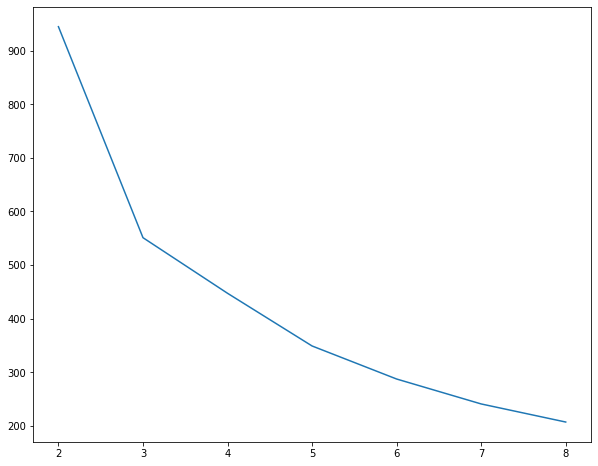

In [61]:
actif_final_inner_std=pd.DataFrame(StandardScaler().fit_transform(actif_final_inner[['recency_x','freq_x','money']]),columns=[['recency_x','freq_x','money']])
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
ssd=[]
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=90)
    kmeans.fit(actif_final_inner_std[['recency_x','freq_x','money']])
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(actif_final_inner_std[['recency_x','freq_x','money']], cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1},inertia is {2}".format(num_clusters, silhouette_avg,kmeans.inertia_))
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(range_n_clusters,ssd)

In [62]:
def actif_seg(x):
    if x==1:
           return'champion'
    elif x==2:
           return'sleep_champ'
    else:
           return'mid_champ'
actif_final_inner['category'] =actif_final_inner.act_cluster.apply(actif_seg)

In [63]:
actif_final_inner.head()

,avg_diff_x,cluster,cluster2,driver,fre_rel,freq_x,recency_x,work_duration_x,freq_y,last_trip,...,dist,dist_trip,money,mon_trip,mon_month,recency_y,avg_diff_y,work_duration_y,act_cluster,category
0,0.069578,4,0.0,7bdac954f2be7f55aa04f12e4be5d954c1d0d42a237bb5...,14.379562,1970,0,137,1970,2018-07-01 00:00:00+00:00,...,9380.80,4.761827,33688.45,17.100736,5614.741667,0,0.069578,137,2,sleep_champ
1,0.058000,4,0.0,e0e4d2903696d6f25cb9ff81598d69162bd959eaf4a2c1...,17.248276,2501,0,145,2501,2018-07-01 00:00:00+00:00,...,12119.40,4.845822,38959.25,15.577469,6493.208333,0,0.058000,145,1,champion
2,0.072736,4,0.0,47ca4f095132747492a937ca57f97785cadf5af5d09be7...,13.754839,2132,26,155,2132,2018-06-05 12:30:00+00:00,...,9453.00,4.433865,29865.75,14.008326,4977.625000,26,0.072736,155,2,sleep_champ
3,0.065934,4,0.0,853278b8e858dc5d220650acd4dc18dfd00c0175157e46...,15.173077,2367,25,156,2367,2018-06-06 12:00:00+00:00,...,7016.23,2.964187,26965.50,11.392269,4494.250000,25,0.065934,156,2,sleep_champ
4,0.061224,4,0.0,1bff274ed006935422e0042a5b4ba149e8ea9d59666cd6...,16.339744,2549,25,156,2549,2018-06-06 14:30:00+00:00,...,8998.60,3.530247,31989.75,12.549922,5331.625000,25,0.061224,156,1,champion


## Actif groups money contribution in each category:

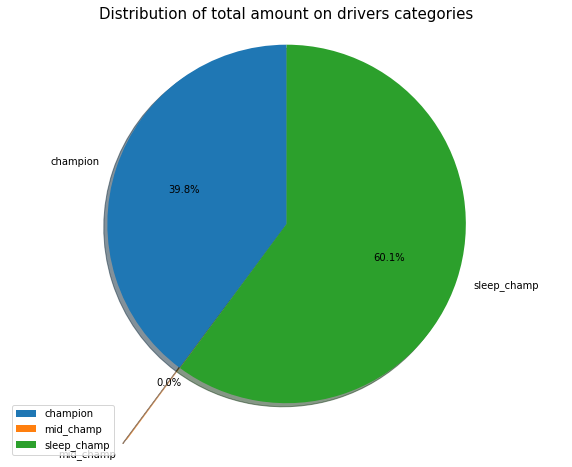

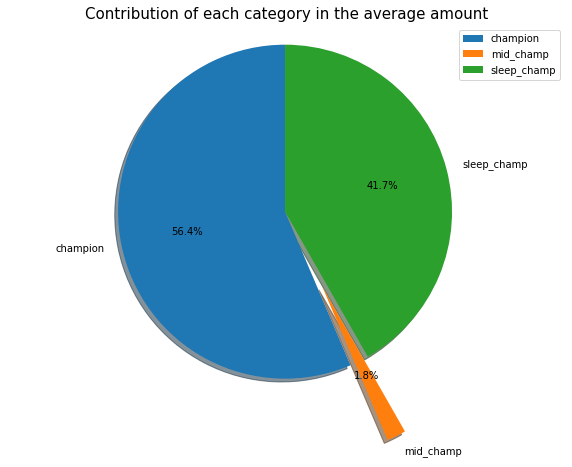

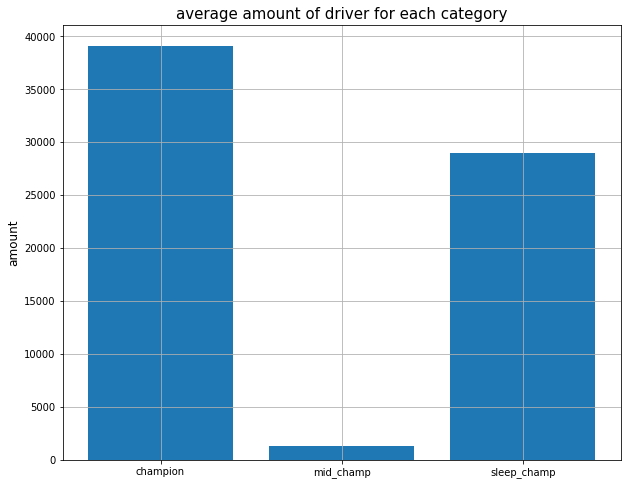

In [64]:
actif_final_inner.groupby('category').sum()['money'].values
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = actif_final_inner.groupby('category').sum()['money'].index
sizes = actif_final_inner.groupby('category').sum()['money'].values
sizes2 = (actif_final_inner.groupby('category').sum()['money']/actif_final_inner.groupby('category').count()['money']).values
explode = (0, 0.5, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of total amount on drivers categories',size=15)
plt.legend()
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(sizes2, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Contribution of each category in the average amount',size=15)
plt.legend()
plt.show()



plt.bar(x=labels,height=sizes2)
plt.title('average amount of driver for each category',size=15)
plt.ylabel('amount',size=12)
plt.grid()

## Remarks:
* We see that mid champions bring more money in total then champions in total !

* But the average mid champ brings amount just like sleep champ! 

* champions brings the more money/driver for each dollar a champion brings 0.42

## Frequency study for each actif group

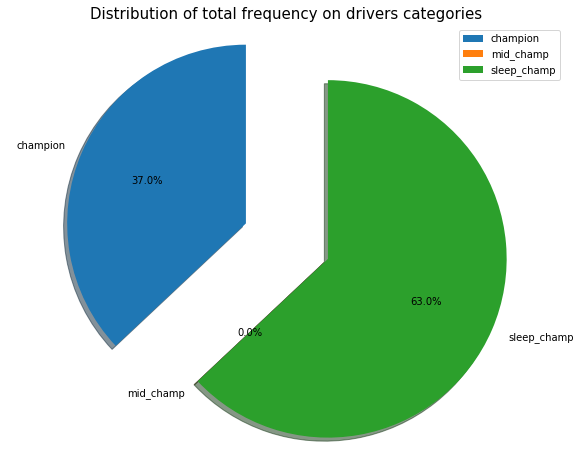

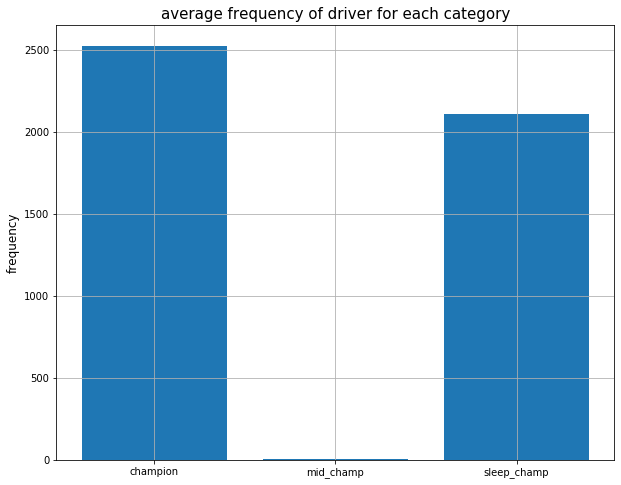

In [65]:
actif_final_inner.groupby('category').sum()['freq_x'].values
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = actif_final_inner.groupby('category').sum()['freq_x'].index
sizes = actif_final_inner.groupby('category').sum()['freq_x'].values
sizes2 = (actif_final_inner.groupby('category').sum()['freq_x']/actif_final_inner.groupby('category').count()['freq_x']).values
explode = (0.5, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of total frequency on drivers categories',size=15)
plt.legend()
plt.show()

plt.bar(x=labels,height=sizes2)
plt.title('average frequency of driver for each category',size=15)
plt.ylabel('frequency',size=12)
plt.grid()


NameError: name 'vals' is not defined

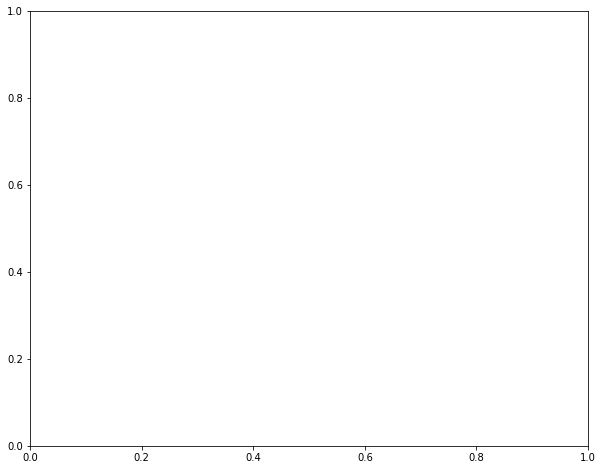

In [66]:
fig, ax = plt.subplots()
fig.size=(20,20)
size = 0.4
vals = vals

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(5)*4)
inner_colors = cmap(np.array([1, 2, 3,5,7,30]))

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,explode=[0.,0,0],
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,explode=[0.1,0,0,0,0,0,0,0,0],
       wedgeprops=dict(width=size, edgecolor='w'),rotatelabels =True,labels=['champions','mid_champ','sleep_champ','Average','none','none','Inactif','none','none'])

ax.set(aspect="equal", title='Money Distribution over all categories')
plt.show()

In [ ]:
print(f'actif money is {actif_money} and mid money is {mid_money} and inactif money is {inactif_money}')
actif_champ_money=actif_champ_money
outer=[actif_money,mid_money,inactif_money]

In [67]:
data = dict(
    character=["money","Actif", "middle_class", "Inactif","champion", "mid_champion", "sleep_champion"],
    parent=["", "money", "money", "money", "Actif", "Actif","Actif"],
    value=value)

fig =px.sunburst(
    data,
    names='character',
    parents='parent',
    values='value',
)
fig.update_layout(
    grid= dict(columns=2, rows=1),
    margin = dict(t=0, l=0, r=0, b=0)
)
fig.show()


NameError: name 'value' is not defined

In [ ]:
actif_money_details=actif_final_inner.groupby('category').sum()['money'].values
value=np.concatenate((total2,outer,actif_money_details))
total=actif_money+mid_money+inactif_money
total2=np.array(total)
total2=total2.reshape((1,))
value.shape

In [ ]:
vals=np.array([actif_money_details,[mid_money,0,0],[inactif_money,0,0]])
vals.shape

total

In [ ]:
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

vals

In [ ]:
vals.flatten().shape